# Import Library

In [56]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import nltk
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse as sp
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense,Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Import Dataset

In [15]:
df=pd.read_csv(r"..\DATASET\recommendation system\1000_dummy_product.csv")
df.head()

,ID,Deskripsi Produk,Merek,Kategori,Harga Sewa,Preferensi Pengguna,Jumlah Stok
0,1,Kamera Mirrorless,Sony,Camera,200000,"Fotografi, Ringan, Kinerja",5
1,2,Speaker Bluetooth,JBL,Speaker,100000,"Bergaya, Portabel",3
2,3,Proyektor Mini,Epson,Proyektor,150000,"Kinerja, Mudah Digunakan",2
3,4,Playstation 5,Sony,Playstation,250000,"Mewah, Gaming",4
4,5,Tenda Camping 4 Orang,Coleman,Tenda,50000,"Nyaman, Ringan, Tahan Lama",6


In [16]:
df.tail()

,ID,Deskripsi Produk,Merek,Kategori,Harga Sewa,Preferensi Pengguna,Jumlah Stok
995,996,Tas Camping Deuter Aircontact Lite 40+10,Deuter,Tas Camping,1700000,"Tahan Air,Tahan Lama",5
996,997,Kamera Mirrorless Fujifilm X-T4,Fujifilm,Camera,8000000,"Fotografi,Kualitas Tinggi",3
997,998,Speaker Bluetooth Sony SRS-XB43,Sony,Speaker,3000000,"Portabel,Suara Kualitas Tinggi",4
998,999,Proyektor HD ViewSonic PX747-4K,ViewSonic,Proyektor,6500000,"Kualitas Gambar Tinggi, Terang",3
999,1000,PlayStation 4 Pro,Sony,Playstation,4000000,"Gaming,Kualitas Grafis Tinggi",3


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   1000 non-null   int64 
 1   Deskripsi Produk     1000 non-null   object
 2   Merek                1000 non-null   object
 3   Kategori             1000 non-null   object
 4   Harga Sewa           1000 non-null   int64 
 5   Preferensi Pengguna  1000 non-null   object
 6   Jumlah Stok          1000 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 54.8+ KB


# Prepocessing

### Data Cleaning

In [18]:
df.Kategori.unique()

array(['Camera', 'Speaker', 'Proyektor', 'Playstation', 'Tenda', 'Sepatu',
       'Matras', 'Tas', 'Furniture', 'Headset', 'Laptop', 'Mesin Cuci',
       'Smartphone', 'Sepeda', 'TV', 'Soundbar', 'Alat Musik',
       'Smartwatch', 'Perkakas', 'Dapur', 'Outdoor', 'Videocam', 'Audio',
       'Koper', 'Perangkat Keamanan', 'Printer', 'Monitor', 'Drone',
       'Alat Fitness', 'Perangkat Streaming', 'Mikrofon', 'Kamera Aksi',
       'Keyboard', 'Smart TV', 'Mesin Jahit', 'Kulkas', 'Kamera',
       'Tas Camping'], dtype=object)

In [19]:
df.Kategori.value_counts()

Speaker                140
Proyektor              105
Tenda                  104
Sepatu                 104
Matras                 103
Playstation            101
Kamera                  81
Tas                     67
Camera                  42
Tas Camping             36
Dapur                   22
Alat Musik              12
Laptop                  12
Perkakas                 8
Furniture                7
Smartphone               7
Outdoor                  7
Smart TV                 5
Monitor                  4
Drone                    4
Alat Fitness             4
Kulkas                   3
Mesin Jahit              3
Printer                  2
Perangkat Streaming      2
Headset                  2
Mikrofon                 2
Keyboard                 1
Kamera Aksi              1
Sepeda                   1
TV                       1
Mesin Cuci               1
Koper                    1
Audio                    1
Videocam                 1
Smartwatch               1
Soundbar                 1
P

In the "category" attribute there are several values that have similarities so that they can be combined into one value such as:
- 'camera' , 'Kamera Aksi' rename to 'Kamera'
- 'Tas Camping' rename to 'Tas'

In [20]:
for column in df.Kategori:
    df['Kategori'] = df['Kategori'].replace('Camera', 'Kamera')
    df['Kategori'] = df['Kategori'].replace('Kamera Aksi', 'Kamera')
    df['Kategori'] = df['Kategori'].replace('Tas Camping', 'Tas')

df.Kategori.value_counts()

Speaker                140
Kamera                 124
Proyektor              105
Tenda                  104
Sepatu                 104
Matras                 103
Tas                    103
Playstation            101
Dapur                   22
Alat Musik              12
Laptop                  12
Perkakas                 8
Outdoor                  7
Smartphone               7
Furniture                7
Smart TV                 5
Alat Fitness             4
Drone                    4
Monitor                  4
Mesin Jahit              3
Kulkas                   3
Printer                  2
Perangkat Streaming      2
Mikrofon                 2
Headset                  2
Videocam                 1
Audio                    1
Koper                    1
Perangkat Keamanan       1
Soundbar                 1
TV                       1
Sepeda                   1
Keyboard                 1
Mesin Cuci               1
Smartwatch               1
Name: Kategori, dtype: int64

To handle unbalanced data on the 'Kategori' attribute, categories that have a number < 10 will be deleted.

In [21]:
# Count the number of data per category
category_counts = df['Kategori'].value_counts()

# Find categories with less than 10 data
categories_less_than_10 = category_counts[category_counts < 10].index

# Remove rows with categories that have less than 10 data
df = df[~df['Kategori'].isin(categories_less_than_10)]


### Feature Selection

In [22]:
# Menghapus atribut "ID" 
df1 = df.drop(['ID'], axis=1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 930 entries, 0 to 999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Deskripsi Produk     930 non-null    object
 1   Merek                930 non-null    object
 2   Kategori             930 non-null    object
 3   Harga Sewa           930 non-null    int64 
 4   Preferensi Pengguna  930 non-null    object
 5   Jumlah Stok          930 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 50.9+ KB


### Normalization

In [23]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Take the "Harga Sewa" column and reshape it into an array
harga_sewa = df1['Harga Sewa'].values.reshape(-1, 1)

# Perform Min-Max Scaling on the "Harga Sewa" column
harga_sewa_scaled = scaler.fit_transform(harga_sewa)

# Replace the values in the "Harga Sewa" column with the scaled values
df1['Harga Sewa'] = harga_sewa_scaled

df1.head()


,Deskripsi Produk,Merek,Kategori,Harga Sewa,Preferensi Pengguna,Jumlah Stok
0,Kamera Mirrorless,Sony,Kamera,0.008513,"Fotografi, Ringan, Kinerja",5
1,Speaker Bluetooth,JBL,Speaker,0.003505,"Bergaya, Portabel",3
2,Proyektor Mini,Epson,Proyektor,0.006009,"Kinerja, Mudah Digunakan",2
3,Playstation 5,Sony,Playstation,0.011017,"Mewah, Gaming",4
4,Tenda Camping 4 Orang,Coleman,Tenda,0.001002,"Nyaman, Ringan, Tahan Lama",6


### Label Encoding

In [24]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encoding attribute "Merek"
df1['Merek'] = label_encoder.fit_transform(df1['Merek'])



### One Hot encoding

In [25]:
# Perform one-hot encoding on the 'Kategori' attribute
one_hot_encoded = pd.get_dummies(df1['Kategori'])

# Concatenate the one-hot encoded dataframe with the original dataframe
df1 = pd.concat([df1, one_hot_encoded], axis=1)

# Remove the 'Kategori' column that is no longer needed after one-hot encoding
df1 = df1.drop('Kategori', axis=1)

df1.head(10)

,Deskripsi Produk,Merek,Harga Sewa,Preferensi Pengguna,Jumlah Stok,Alat Musik,Dapur,Kamera,Laptop,Matras,Playstation,Proyektor,Sepatu,Speaker,Tas,Tenda
0,Kamera Mirrorless,93,0.008513,"Fotografi, Ringan, Kinerja",5,0,0,1,0,0,0,0,0,0,0,0
1,Speaker Bluetooth,48,0.003505,"Bergaya, Portabel",3,0,0,0,0,0,0,0,0,1,0,0
2,Proyektor Mini,30,0.006009,"Kinerja, Mudah Digunakan",2,0,0,0,0,0,0,1,0,0,0,0
3,Playstation 5,93,0.011017,"Mewah, Gaming",4,0,0,0,0,0,1,0,0,0,0,0
4,Tenda Camping 4 Orang,22,0.001002,"Nyaman, Ringan, Tahan Lama",6,0,0,0,0,0,0,0,0,0,0,1
5,Sepatu Olahraga,68,0.002504,"Bergaya, Nyaman",10,0,0,0,0,0,0,0,1,0,0,0
6,Matras Angin Tidur,47,0.000000,"Nyaman, Praktis",8,0,0,0,0,1,0,0,0,0,0,0
7,Tas Punggung Anti Air,97,0.004507,"Bergaya, Tahan Air",3,0,0,0,0,0,0,0,0,0,1,0
8,Kamera DSLR,17,0.007511,"Fotografi, Kualitas Gambar",7,0,0,1,0,0,0,0,0,0,0,0
9,Speaker Portable,13,0.006009,"Kinerja, Suara Berkualitas",5,0,0,0,0,0,0,0,0,1,0,0


### Text Standardization

In [26]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
# Initialize WordNetLemmatizers
lemmatizer = WordNetLemmatizer()

# Function to preprocess text
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text into words
    tokens = nltk.word_tokenize(text)
    # Lemmatize words
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join the tokens back into a single string
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

# Standardize text in "Deskripsi Produk" attribute
df1['Deskripsi Produk'] = df1['Deskripsi Produk'].apply(preprocess_text)

# Standardize text in "Preferensi Pengguna" attribute
df1['Preferensi Pengguna'] = df1['Preferensi Pengguna'].apply(preprocess_text)


# Feature Representation

In [28]:
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# TF-IDF representation for "Deskripsi Produk" feature
deskripsi_produk_tfidf = tfidf_vectorizer.fit_transform(df1['Deskripsi Produk'])

# TF-IDF representation for "Preferensi Pengguna" feature
preferensi_pengguna_tfidf = tfidf_vectorizer.fit_transform(df1['Preferensi Pengguna'])

# Combine the two representation matrices into one matrix
feature_matrix = sp.hstack((deskripsi_produk_tfidf, preferensi_pengguna_tfidf))

# Split data

In [31]:
target_data = df1.drop(['Deskripsi Produk', 'Merek', 'Harga Sewa', 'Preferensi Pengguna', 'Jumlah Stok'], axis=1)

# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(feature_matrix.toarray(), target_data.to_numpy(), test_size=0.2, random_state=42)


In [40]:
feature_matrix.shape

(930, 481)

In [34]:
target_data.to_numpy()

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [53]:
# Define the number of input features
input_dim = X_train.shape[1]

# Initialize the model
model = Sequential()

# Add the output layer with the appropriate number of classes
num_classes = y_train.shape[1]

# Add the input layer and hidden layer
model.add(Dense(128, input_dim=input_dim, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with the training data
hist = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))



Epoch 1/10
12/12 [==============================] - 1s 20ms/step - loss: 2.3275 - accuracy: 0.2258 - val_loss: 2.2406 - val_accuracy: 0.3011
Epoch 2/10
12/12 [==============================] - 0s 9ms/step - loss: 2.1262 - accuracy: 0.3777 - val_loss: 1.9805 - val_accuracy: 0.4301
Epoch 3/10
12/12 [==============================] - 0s 9ms/step - loss: 1.7916 - accuracy: 0.4704 - val_loss: 1.5677 - val_accuracy: 0.6183
Epoch 4/10
12/12 [==============================] - 0s 7ms/step - loss: 1.3598 - accuracy: 0.6196 - val_loss: 1.0990 - val_accuracy: 0.7151
Epoch 5/10
12/12 [==============================] - 0s 6ms/step - loss: 0.9090 - accuracy: 0.8199 - val_loss: 0.6763 - val_accuracy: 0.8925
Epoch 6/10
12/12 [==============================] - 0s 6ms/step - loss: 0.5505 - accuracy: 0.9086 - val_loss: 0.4006 - val_accuracy: 0.9355
Epoch 7/10
12/12 [==============================] - 0s 6ms/step - loss: 0.3552 - accuracy: 0.9355 - val_loss: 0.2618 - val_accuracy: 0.9409
Epoch 8/10
12/12 [=

In [55]:
# Prediksi nilai menggunakan model
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Menghitung MSE dan MAE
train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)

train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)

print("MSE pada data latih: ", train_mse)
print("MSE pada data uji: ", test_mse)

print("MAE pada data latih: ", train_mae)
print("MAE pada data uji: ", test_mae)


6/6 [==============================] - 0s 2ms/step
MSE pada data latih:  0.002200366
MSE pada data uji:  0.0044997
MAE pada data latih:  0.0077624465
MAE pada data uji:  0.012032791


***Display the training accuracy plot***

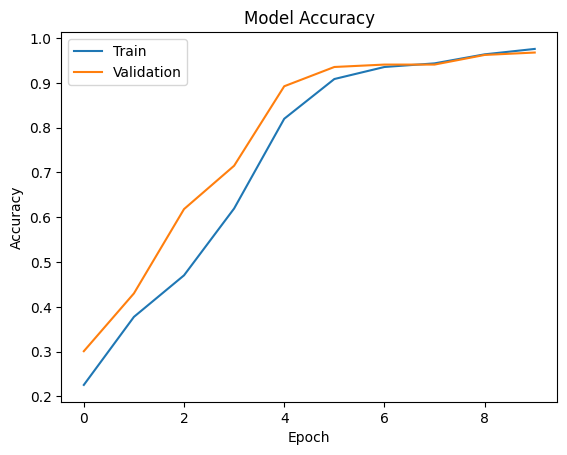

In [57]:
# Menampilkan plot akurasi pelatihan
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

***Display the training loss plot***

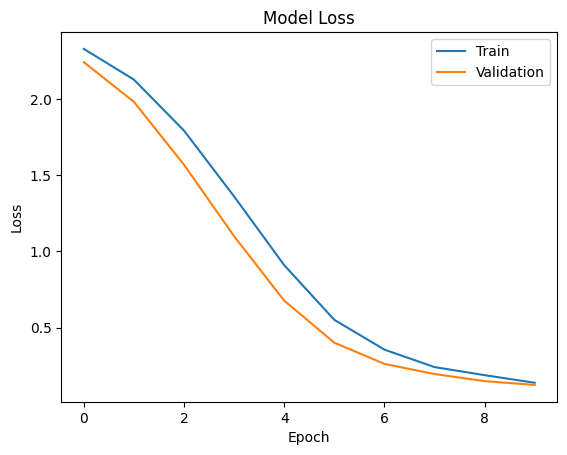

In [58]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()